In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import dependencies

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
% pip install wandb

In [2]:
import numpy as np
from os.path import isfile, exists
import random
import utils
from code_HGN_senEM_test import define_model, session_run
prev_img_idx = 0 # Needed for saving image

print('Load needed things!')

Load needed things!


### Load preprocessed data

In [3]:
relative_data_directory_path = '/content/drive/MyDrive/Speech2Pickup/data_v1.2_single_channel/preprocessed4HGN_speech2pickup.npz'

data = np.load(relative_data_directory_path)

img_idx = data['img_idx']
sen_len = data['seq_len']
speech_inputs = data['inputs']
pos_outputs = data['outputs']
sentence = data['sentence']

print('End loading MetaData')

num_data = img_idx.shape[0]

End loading MetaData


### Define Model : Run this cell only once per one kernel 

In [4]:
n_mels = 40
time_steps = 303
dropout_rate = 0.1
encoder_args = {'num_stacks': 3, 'num_channels':[n_mels for i in range(6)], 'kernel_size':3,
                'dropout_rate': dropout_rate, 'activation': 'leaky-relu', 'return_type': 'end'}
input_shapes = (None, n_mels, time_steps)
seed = 1
training_state = True  # Even testing, training set should be set 'True' due to written code mistake

result_heatmap, ph_image, ph_speech, ph_dropout = define_model(n_mels = 40,
                                                               time_steps = 303,
                                                               num_hg_Depth = 4,
                                                               dim_hg_feat = 256,
                                                               encoder_args = encoder_args,
                                                               input_shapes = input_shapes,
                                                               seed = seed,
                                                               training_state = training_state)



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.cast` instead.



### Get test image index. Refer the printed result when you check the result from the test data

In [6]:
idx_test, idx_train = utils.get_test_idx(img_idx, num_data)

Test image index : [154  47  59  31 419 446 217  63 152 236 289 229 434  67  45 316 352 135
 285  77 318  41 142]


### Choose the image index for the test

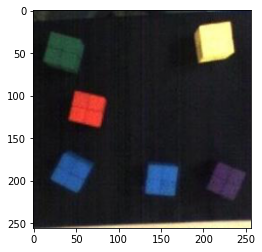

In [7]:
test_img_idx = 154
img_path = '/content/drive/MyDrive/Speech2Pickup/train_img'
curr_test_img = utils.load_test_img(img_path, test_img_idx, img_resize=256, plot_flag = 1)

### Set speech input and Run the Result 
(sentence command in the open datatset)

In [23]:
# curr_test_input = "pick up the right block the green one"
# curr_embed_input, curr_seq_len = utils.load_test_script(curr_test_input, w2v_model, 
#                                                         dim_sentence, max_step_sentence)
num_data_idx = random.choice(np.where(img_idx == test_img_idx)[0])
curr_speech = speech_inputs[num_data_idx, :, :]
curr_sentence = sentence[num_data_idx]

mean_of_esti, uncertainty = session_run(result_heatmap=result_heatmap,
                                        ph_image=ph_image,
                                        ph_speech=ph_speech,
                                        ph_dropout=ph_dropout,
                                        curr_test_img=curr_test_img,
                                        curr_speech=curr_speech,
                                        dropout_rate=dropout_rate,
                                        restore_path = '/content/drive/MyDrive/Speech2Pickup/HGN_senEM_model/model.ckpt')

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Speech2Pickup/HGN_senEM_model/model.ckpt


### Set speech input and Run the Result 
(sentence command given by you)

https://stackoverflow.com/questions/54995034/is-it-possible-to-call-google-cloud-apis-from-google-colab

In [ ]:
pip install librosa==0.8.0

In [21]:
import librosa
# from text_to_speech import text_to_speech_for_model_test
from process_data import return_mel_spec_single_channel

voice_config = {'accent': 'en-US',
                'gender': 'MALE'}
"""
Check https://cloud.google.com/text-to-speech/docs/voices for available voice configurations
'Speech2Pickup' supports only English
"""
# Fill in ##### with the command you like to give.
curr_sentence = '######'
text_to_speech_for_model_test(sentence=curr_sentence, voice_config=voice_config)
sampled_audio, sample_rate = librosa.load('/content/output.wav', sr=16000)

max_audio_len = 77520
n_fft = 2048
hop_length = int(n_fft/8)
win_length = int(n_fft/2)
if len(sampled_audio) > max_audio_len:
    raise ValueError('Too long audio length')
sampled_audio = np.append(sampled_audio, [0]*(max_audio_len-sampled_audio.shape[0]))

# Extract mel feature
curr_speech = return_mel_spec_single_channel(sampled_audio=sampled_audio,
                                             sample_rate=sample_rate,
                                             n_fft=n_fft,
                                             hop_length=hop_length,
                                             win_length=win_length,
                                             n_mels=n_mels,
                                             window='hann',
                                             log_scale=True)
curr_speech = curr_speech[np.newaxis, :, :]

# Get the model output
mean_of_esti, uncertainty = session_run(result_heatmap=result_heatmap,
                                        ph_image=ph_image,
                                        ph_speech=ph_speech,
                                        ph_dropout=ph_dropout,
                                        curr_test_img=curr_test_img,
                                        curr_speech=curr_speech,
                                        dropout_rate=dropout_rate,
                                        restore_path = '/content/drive/MyDrive/Speech2Pickup/HGN_senEM_model/model.ckpt')


INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Speech2Pickup/HGN_senEM_model/model.ckpt


### See the Result

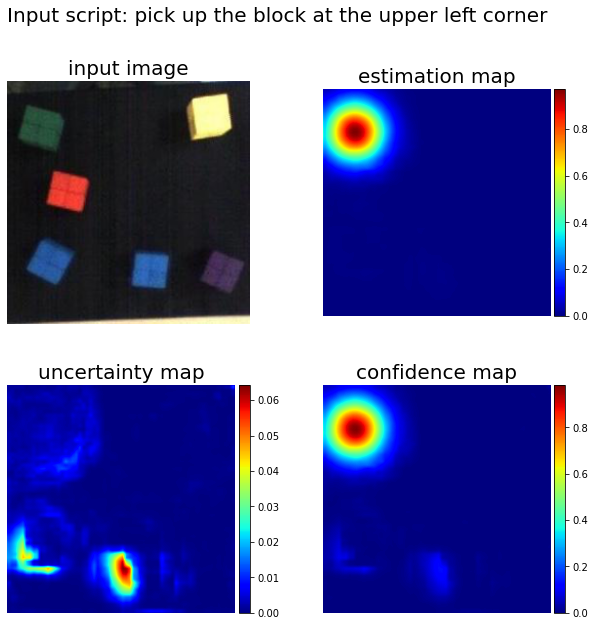

In [24]:
import os
import matplotlib.pyplot as plt

if prev_img_idx != test_img_idx:
    num = 1
file_name = '/content/drive/MyDrive/Speech2Pickup/result/HGN_senEM/{}_{}'.format(test_img_idx, num)
utils.plot_HGN_result(curr_sentence, curr_test_img, mean_of_esti, uncertainty, save_state=False, save_path=file_name)
prev_img_idx = test_img_idx
num += 1